Imports

In [1]:
#Display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact
from tqdm import tqdm, trange
#Numerics
import numpy as np
import jax
import jax.numpy as jnp
#Functional
from typing import List, Callable
from functools import partial
#Own
from data_gen import gen_data
from data_gen_x import gen_data_x
from models import *

# Analysis for Sound Discrimination Models

Idea: In the `models` module, we have two Models , `OneLayer` and `TwoLayer`, with a training method `run_scheme`.

This method can run different versions of active and passive training iterations, specified by the argument `active_cond`. This should be a function mapping an index `i` to the Boolean `True` if iteration `i` is active and `False` if it is passive. The module `models` contains the functions `an_cond`, `ap_cond` and `pta_cond` for our convenience.

During training, the model's validation accuracies and psychometric curves are stored in its `metric` attribute. If we set the `debug` parameter to `True`, this attribute also records all weights and hidden activities during training (caution: this is very memory-intensive).

With `jax.vmap`, we can run several sessions with different random seeds in parallel on the GPU.

In [10]:
def simulation(seed: int, num_it: int=2000, cond: Callable=an_cond, lr_sgd: float=1e-2, lr_hebb: float=4e-3):
    """
    Prepare test and validation data and run simulation.
    :param seed: Random PRNG seed
    :param num_it: Number of iterations to run
    :param cond: Function specifying if iteration i is an active or only passive trial.
    :param lr_sgd: SGD learning rate for v
    :param lr_hebb: Hebbian learning rate for v
    """
    jax_key = jax.random.PRNGKey(seed)
    
    #Prepare means of point clouds
    data_means = parclass_wv().means * jax.random.uniform(jax_key, minval=0.3)
    
    X_train, y_train, _ = gen_data_x(jax_key, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True)
    jax_key, subkey1, subkey2 = jax.random.split(jax_key, 3)
    X_val, y_val, _ = gen_data_x(subkey1, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True)
    
    sim_pars = parclass_v(lr_sgd_v=lr_sgd, lr_hebb_v=lr_hebb, lam_sgd_v=1e-4, lam_hebb_v=2e-1)
    sim_pars.means = data_means
    
    test_single = OneLayer(subkey2, pars = sim_pars)
    test_single.run_scheme(cond, X_train, y_train, X_val, y_val, num_it)
    return test_single.metrics

In [11]:
def simulation_double(seed: int, num_it: int=2000, cond: Callable=an_cond, lr_sgd_v: float=0, lr_hebb_v: float=1e-4, lr_sgd_w: float=1e-3, lr_fsm_w: float=2e-3, hebb_w: bool=False):
    """
    Prepare test and validation data and run simulation.
    :param seed: Random PRNG seed
    :param num_it: Number of iterations to run
    :param cond: Function specifying if iteration i is an active or only passive trial.
    :param lr_sgd_v: SGD learning rate for v
    :param lr_hebb_v: Hebbian learning rate for v
    :param lr_sgd_w: SGD learning rate for W
    :param lr_fsm_w: FSM/Hebbian learning rate for W
    :param hebb_w: If True, use Hebbian learning for W, otherwise FSM
    """
    jax_key = jax.random.PRNGKey(seed)
    
    #Prepare means of point clouds
    data_means = parclass_wv().means * jax.random.uniform(jax_key, minval=0.3)
    
    X_train, y_train, _ = gen_data_x(jax_key, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True)
    jax_key, subkey1, subkey2 = jax.random.split(jax_key, 3)
    X_val, y_val, _ = gen_data_x(subkey1, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True)
    
    sim_pars = parclass_wv(lam_fsm_w=0, lam_sgd_w=1e-3, lam_hebb_v=4e-1, lam_sgd_v=5e-2, lr_hebb_v=lr_hebb_v, lr_fsm_w=lr_fsm_w, lr_sgd_w=lr_sgd_w, lr_sgd_v=lr_sgd_v, hebb_w=hebb_w)
    sim_pars.means = data_means
    
    test_double = TwoLayer(subkey2, pars=sim_pars)
    test_double.run_scheme(cond, X_train, y_train, X_val, y_val, num_it)
    return test_double.metrics

## One Layer Model

Run this simulation for random seeds in `range(100)` in parallel for all conditions.

In [12]:
an_onel = jax.vmap(lambda seed: simulation(seed, cond=an_cond, num_it=4000))(jnp.arange(100))

(4000,)


In [13]:
ap_onel = jax.vmap(lambda seed: simulation(seed, cond=ap_cond, num_it=40000))(jnp.arange(100))

(40000,)


In [17]:
pta_onel = jax.vmap(lambda seed: simulation(seed, cond=pta_cond, num_it=40000))(jnp.arange(100))

(40000,)


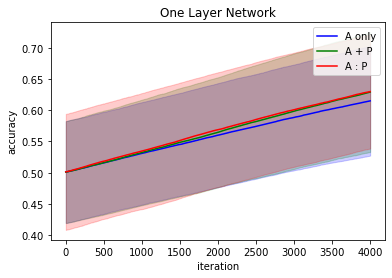

In [15]:
to_draw = [[an_onel[1][0], "A only", "blue"], [ap_onel[1][0][:,::10], "A + P", "green"], [pta_onel[1][0][:,-4000:], "A : P", "red"]]
for data, label, color in to_draw:
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(data_mean, label=label, color=color)
    plt.fill_between(np.arange(len(data_mean)), data_mean-data_std, data_mean+data_std, alpha=0.2, color=color)
plt.legend()
plt.title('One Layer Network')
plt.xlabel('iteration');
plt.ylabel('accuracy');
plt.show()

## Two Layer Model

In [7]:
an_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=an_cond, num_it=4000, lr_sgd_v=0, lr_hebb_v=5e-4, lr_sgd_w=5e-2, lr_fsm_w=4e-3, hebb_w=True))(jnp.arange(100))

(4000,)


In [5]:
ap_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=ap_cond, num_it=40000, lr_sgd_v=0, lr_hebb_v=5e-4, lr_sgd_w=5e-2, lr_fsm_w=4e-3, hebb_w=True))(jnp.arange(100))

(40000,)


In [6]:
pta_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=pta_cond, num_it=40000, lr_sgd_v=0, lr_hebb_v=5e-4, lr_sgd_w=5e-2, lr_fsm_w=4e-3, hebb_w=True))(jnp.arange(100))

(40000,)


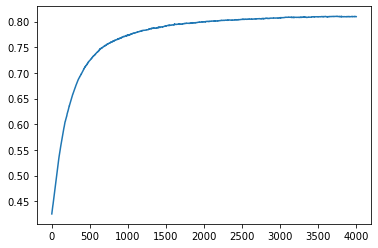

In [8]:
plt.plot(an_doublel_sw[1][0][np.where(an_doublel_sw[1][0][:,0]<0.5)].mean(axis=0))